In [4]:
import numpy as np

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

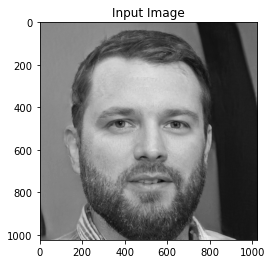

In [2]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('fake.png')

R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
plt.title('Input Image')
plt.imshow(imgGray, cmap='gray')
plt.show()

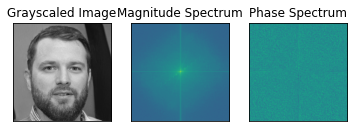

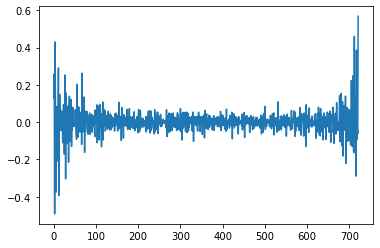

In [6]:
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array
f = np.fft.fft2(imgGray)
#f = np.fft.fft2(B)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
phase_spectrum = np.angle(fshift)
plt.subplot(131),plt.imshow(imgGray, cmap = 'gray')
plt.title('Grayscaled Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(magnitude_spectrum)
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(phase_spectrum)
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()
#psd1D = azimuthalAverage(magnitude_spectrum)
#plt.plot(psd1D)
psd1D = azimuthalAverage(phase_spectrum)
plt.plot(psd1D)

In [15]:
new_spectrum = phase_spectrum - phase_spectrum.min()

In [19]:
new_spectrum = new_spectrum*255/new_spectrum.max()

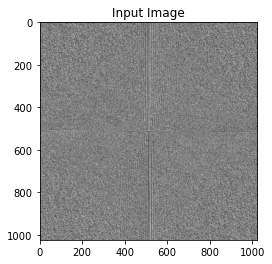

In [22]:
plt.title('Input Image')
plt.imshow(new_spectrum, cmap='gray')
plt.show()

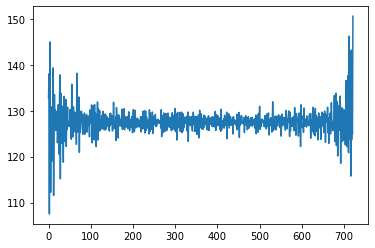

In [20]:
psd1D = azimuthalAverage(new_spectrum)
plt.plot(psd1D)

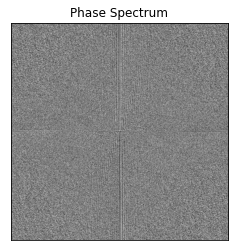

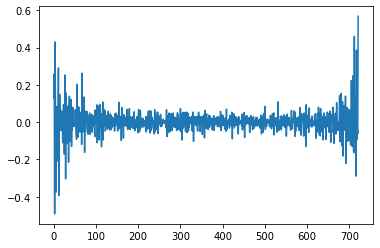

In [49]:
plt.imshow(phase_spectrum, cmap='gray')
plt.title('Phase Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()
plt.plot(azimuthalAverage(phase_spectrum))

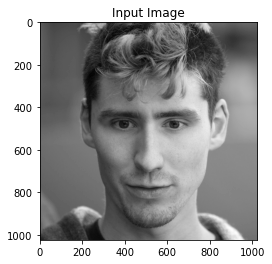

In [31]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('real.png')

R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
plt.title('Input Image')
plt.imshow(imgGray, cmap='gray')
plt.show()

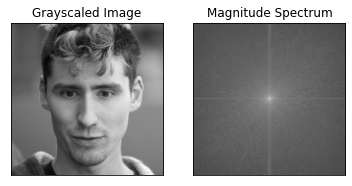

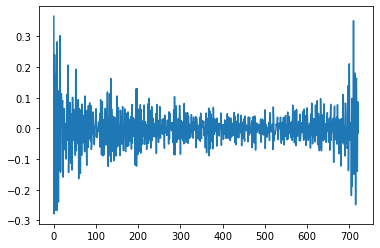

In [32]:
import numpy as np
f = np.fft.fft2(imgGray)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
phase_spectrum = np.angle(fshift)
plt.subplot(121),plt.imshow(imgGray, cmap = 'gray')
plt.title('Grayscaled Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()
#psd1D = azimuthalAverage(magnitude_spectrum)
#plt.plot(psd1D)
psd1D = azimuthalAverage(phase_spectrum)
plt.plot(psd1D)

In [33]:
psd1D.shape

(722,)

In [2]:
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
folder = 'train/'
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
    # determine class
    output = 0.0
    if file.startswith('real'):#real output = 1, fake output = 0
        output = 1.0
    # load image
    photo = load_img(folder + file, target_size=(1024, 1024))
    # convert to numpy array
    photo = img_to_array(photo)
    # store
    photos.append(photo)
    labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('real_vs_fake.npy', photos)
save('real_vs_fake_labels.npy', labels)


#########Требует слишком много ОЗУ, не запускать на больших датасетах (>12 Гб оперативной памяти)

(5, 1024, 1024, 3) (5,)


In [84]:
from os import listdir
from os import makedirs
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
dataset_home = 'dataset/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['real/', 'fake/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

In [80]:
from shutil import copyfile
from random import seed
from random import random
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'dataset/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    spectrum = get2DSpectrum(src)
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('fake'):
        dst = dataset_home + dst_dir + 'fake/'  + file
        np.save(dst, spectrum)
    elif file.startswith('real'):
        dst = dataset_home + dst_dir + 'real/'  + file
        np.save(dst, spectrum)

OSError: 1048576 requested and 0 written

In [5]:
"""
## Build the model
"""
#input_shape=(1024,1024,1)
input_shape=(300,1)
#input_shape=(200,200,3)
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential(
    [
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(300,1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)
'''
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(722,1)),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.Dropout(0.2),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(1, activation='sigmoid')


        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64, kernel_size=(3, 3),activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(128, kernel_size=(3, 3),activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(activation="relu",units=256),
        layers.Dense(activation="sigmoid",units=1)
        
        
        
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
'''
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 298, 64)           256       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 149, 64)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 147, 128)          24704     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 73, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 71, 256)           98560     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 35, 256)         

In [152]:
import matplotlib.image as mpimg
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

def get2DSpectrum(file):
    img = mpimg.imread(file)
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    f = np.fft.fft2(imgGray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

In [12]:
import numpy as np
from os import listdir
import cv2
import matplotlib.image as mpimg
import pickle

epsilon = 1e-8
data = {}
#number of samples from each dataset
stop = 250
number_iter = 2 * stop
psd1D_total = np.zeros([number_iter, 722])
label_total = np.zeros([number_iter])
iter_ = 0
cont_real = 0
cont_fake = 0
psd1D_average_org = np.zeros(722)
folder = 'trainFFHQ/fake/'
for filename in listdir(folder):
    output = 1
    cont_fake+=1
    img = mpimg.imread(folder+filename)
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    #f = np.fft.fft2(imgGray)
    f = np.fft.fft2(img[:,:,2])
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)
    psd1D_total[iter_,:] = psd1D
    label_total[iter_] = output

    iter_+=1
    if cont_fake >= stop:
        break
print('fake done')
folder = 'trainFFHQ/real/'
for filename in listdir(folder):
    output = 0
    cont_real+=1
    img = mpimg.imread(folder+filename)
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    #f = np.fft.fft2(imgGray)
    f = np.fft.fft2(img[:,:,2])
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)
    psd1D_total[iter_,:] = psd1D
    label_total[iter_] = output

    iter_+=1
    if cont_real >= stop:
        break

data["data"] = psd1D_total
data["label"] = label_total
output = open('dataset_psd1D_1000.pkl', 'wb')
pickle.dump(data, output)
output.close()
print(cont_real,cont_fake)

fake done
250 250


In [1]:
import pickle
pkl_file = open('df_feature_3200_psd1D.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
nrows, ncols = X_train.shape
print(nrows,ncols)
X_train = X_train.reshape(nrows, ncols, 1)
print(X_train.shape)
nrows, ncols = X_test.shape
X_test = X_test.reshape(nrows, ncols, 1)
print(nrows,ncols)
print(X_test.shape)

2560 300
(2560, 300, 1)
640 300
(640, 300, 1)


In [6]:
from tqdm.keras import TqdmCallback
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=20,validation_data=(X_test, y_test), verbose=0,callbacks=[TqdmCallback(verbose=2)])
# evaluate model
#_, acc = model.evaluate_generator(X_test, steps=len(X_test), verbose=0)
#print('> %.3f' % (acc * 100.0))
# learning curves

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]

KeyboardInterrupt: 

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

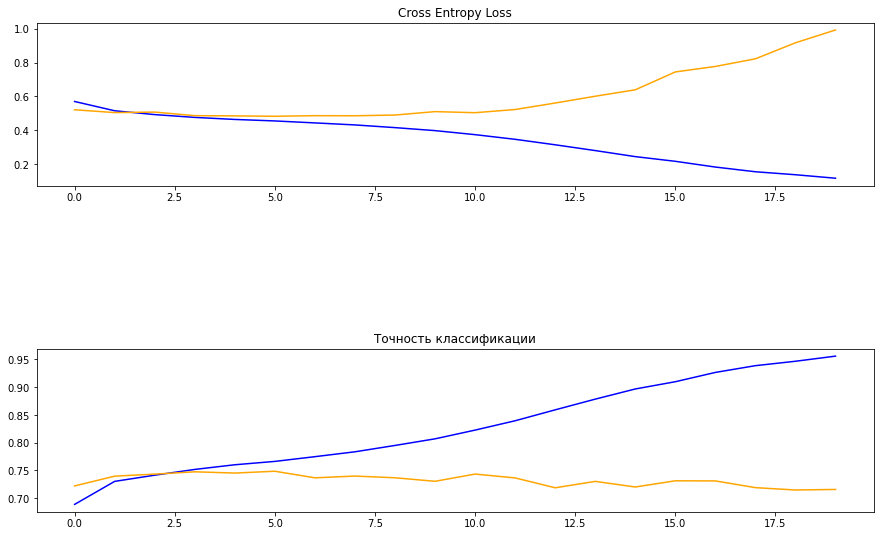

In [53]:
from matplotlib import pyplot
import sys
summarize_diagnostics(history)

In [83]:
from keras.preprocessing.image import ImageDataGenerator
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_it = datagen.flow_from_directory('dataset/train/',class_mode='binary', batch_size=4, target_size=(1024, 1024))
test_it = datagen.flow_from_directory('dataset/test/',class_mode='binary', batch_size=4, target_size=(1024, 1024))#,color_mode='grayscale'

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [75]:
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(train_it), epochs=5, verbose=0, callbacks=[TqdmCallback(verbose=2)])
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history)

0epoch [00:00, ?epoch/s]

C:\Users\ACA8~1\AppData\Local\Temp/ipykernel_13440/2969186634.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(train_it), epochs=5, verbose=0, callbacks=[TqdmCallback(verbose=2)])


  0%|          | 0.00/1.12k [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [22]:
#importing the libraries

from keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback
input_shape = (1024, 1024, 3)
from tensorflow import keras
from keras import layers

"""
## Build the model
"""
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')

    ]
)
'''
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
'''
model.summary()

"""
## Training the model
"""

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_it = datagen.flow_from_directory('dataset/train/',class_mode='binary', batch_size=2, target_size=(1024, 1024))
test_it = datagen.flow_from_directory('dataset/test/',class_mode='binary', batch_size=2, target_size=(1024, 1024))

history = model.fit(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(train_it), epochs=5, verbose=0, callbacks=[TqdmCallback(verbose=2)])
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 1022, 1022, 32)    320       
                                                                 
 conv2d_19 (Conv2D)          (None, 1018, 1018, 32)    25632     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 509, 509, 32)     0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 507, 507, 64)      18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 503, 503, 64)      102464    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 251, 251, 64)     0         
 g2D)                                                 

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/2.25k [00:00<?, ?batch/s]

UnimplementedError: Graph execution error:

Detected at node 'sequential_3/conv2d_18/Relu' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ACA8~1\AppData\Local\Temp/ipykernel_13440/2750814395.py", line 54, in <module>
      history = model.fit(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(train_it), epochs=5, verbose=0, callbacks=[TqdmCallback(verbose=2)])
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 275, in call
      return self.activation(outputs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py", line 4956, in relu
      x = tf.nn.relu(x)
Node: 'sequential_3/conv2d_18/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node sequential_3/conv2d_18/Relu}}]] [Op:__inference_train_function_3645]

In [6]:
def plotSpectrum(X,y):
    num = int(X.shape[0]/2)
    num_feat = X.shape[1]

    psd1D_org_0 = np.zeros((num,num_feat))
    psd1D_org_1 = np.zeros((num,num_feat))
    psd1D_org_0_mean = np.zeros(num_feat)
    psd1D_org_0_std = np.zeros(num_feat)
    #psd1D_org_0_min = np.zeros(num_feat)
    #psd1D_org_0_max = np.zeros(num_feat)
    psd1D_org_1_mean = np.zeros(num_feat)
    psd1D_org_1_std = np.zeros(num_feat)
    #psd1D_org_1_min = np.zeros(num_feat)
    #psd1D_org_1_max = np.zeros(num_feat)

    cont_0=0
    cont_1=0

    # We separate real and fake using the label
    for x in range(X.shape[0]):
        if y[x]==0:
            psd1D_org_0[cont_0,:] = X[x,:]
            cont_0+=1
        elif y[x]==1:
            psd1D_org_1[cont_1,:] = X[x,:]
            cont_1+=1

    # We compute statistcis
    for x in range(num_feat):
        psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
        psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
        #psd1D_org_0_min[x]= np.min(psd1D_org_0[:,x])
        #psd1D_org_0_max[x]= np.max(psd1D_org_0[:,x])
        psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
        #psd1D_org_1_min[x] = np.min(psd1D_org_1[:,x])
        #psd1D_org_1_max[x] = np.max(psd1D_org_1[:,x])
        psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])

    # Plot
    x = np.arange(0, num_feat, 1)
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='green', label='Реальные', linewidth =2.0)
    ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='green', alpha=0.2)
    #ax.fill_between(x, psd1D_org_0_min, psd1D_org_0_max, color='green', alpha=0.2)
    ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='red', label='Сгенерированные', linewidth =2.0)
    ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='red', alpha=0.2)
    #ax.fill_between(x, psd1D_org_1_min, psd1D_org_1_max, color='red', alpha=0.2)
    ax.legend()
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    ax.legend(loc='best', prop={'size': 20})
    plt.xlabel("Расстояние от центра", fontsize=20)
    plt.ylabel("Значения пикселей", fontsize=20)


In [30]:
import numpy as np
from os import listdir
import cv2
import matplotlib.image as mpimg
from tqdm import tqdm
import pickle

epsilon = 1e-8
data = {}
#number of samples from each dataset
stop = 10000

path = ['D:/Dataset/thispersondoesntexists_10K/', 'D:/Dataset/100KFake_10K/','D:/Dataset/Flickr-Faces-HQ_10K/', 'D:/Dataset/celebA-HQ_10K/']
labels = [1,1,0,0]

psd1D_total = np.zeros([stop*4, 722])
label_total = np.zeros([stop*4])
iter_=0
#folder = 'trainFFHQ/fake/'
#folder = 'D:/Dataset/StyleGAN/'
for z in range(4):
    cont = 0
    for filename in tqdm(listdir(path[z])):
        img = mpimg.imread(path[z]+filename)
        R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        f = np.fft.fft2(imgGray)
        fshift = np.fft.fftshift(f)
        fshift += epsilon

        #magnitude_spectrum = 20*np.log(np.abs(fshift))
        phase_spectrum = np.angle(fshift)
        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = azimuthalAverage(phase_spectrum)
        psd1D_total[iter_,:] = psd1D
        label_total[iter_] = labels[z]

        iter_+=1
        cont+=1
        if cont >= stop:
            break
    print(f"{path[z]} done")
        
#folder = 'trainFFHQ/real/'
'''folder = 'D:/Dataset/FFHQ/'
for filename in tqdm(listdir(folder)):
    output = 0
    cont_real+=1
    img = mpimg.imread(folder+filename)
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    f = np.fft.fft2(imgGray)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    #magnitude_spectrum = 20*np.log(np.abs(fshift))
    phase_spectrum = np.angle(fshift)
    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(phase_spectrum)
    psd1D_total[iter_,:] = psd1D
    label_total[iter_] = output

    iter_+=1
    if cont_real >= stop:
        break'''


data["data"] = psd1D_total
data["label"] = label_total
output = open('dataset_phasespectrum_psd1D_40000.pkl', 'wb')
pickle.dump(data, output)
output.close()

100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [49:46<00:00,  3.35it/s]


D:/Dataset/thispersondoesntexists_10K/ done


100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [43:09<00:00,  3.86it/s]


D:/Dataset/100KFake_10K/ done


100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [40:53<00:00,  4.08it/s]


D:/Dataset/Flickr-Faces-HQ_10K/ done


100%|████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [40:29<00:00,  4.12it/s]


D:/Dataset/celebA-HQ_10K/ done


In [3]:
data["data"] = psd1D_total
data["label"] = label_total

In [4]:
output = open('dataset_20000_RadialGray_dist(1,1).pkl', 'wb')
pickle.dump(data, output)
output.close()

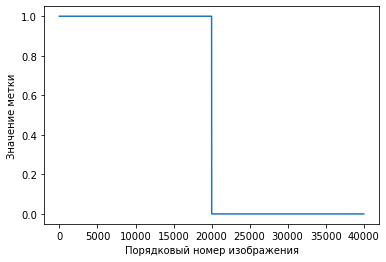

In [32]:
from matplotlib import pyplot as plt
import pickle
pkl_file = open('dataset_phasespectrum_psd1D_40000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
fig, ax = plt.subplots()
ax.plot(y)
ax.set_xlabel('Порядковый номер изображения')
ax.set_ylabel('Значение метки')

plt.show()

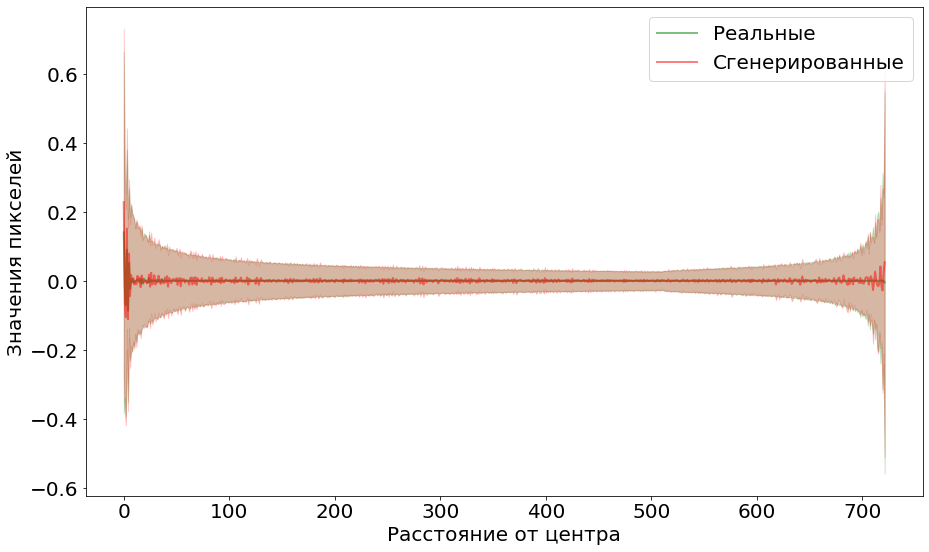

In [7]:
import numpy as np
plotSpectrum(X,y)

In [28]:
#importing the libraries

from keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback
input_shape = (256, 256, 6)
from tensorflow import keras
from keras import layers

"""
## Build the model
"""
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(5, 5)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256),
        layers.Dense(256),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      1760      
                                                                 
 conv2d_13 (Conv2D)          (None, 250, 250, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 119, 119, 64)      102464    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                  

In [17]:
def summarize_diagnostics(history):
    # plot loss
    pyplot.figure(figsize=(15, 9))
    pyplot.subplots_adjust(hspace=1)
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Точность классификации')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.set_xlabel(fontsize=20)
    pyplot.set_ylabel(fontsize=20)

In [158]:
import numpy as np
from os import listdir
import cv2
import matplotlib.image as mpimg
import pickle
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from progress.bar import Bar
from tqdm import tqdm


def glcm(image,shiftx,shifty,levels,image2=None):#image2 is only for cross-band analysis
    
    """Calculate glcm"""
    image = (np.around(image*levels)).astype(np.uint8)
    if image2 is None:
        temp = image
    else:
        image2 = (np.around(image2*levels)).astype(np.uint8)
        temp = image2
    glcm = np.zeros((levels,levels), dtype=np.uint8)
    Nr, Na = image.shape
    for i in range(Nr-shifty):
        for j in range(Na-shiftx):
            glcm[image[i,j], temp[i+shifty, j+shiftx]]+=1
    return glcm

def combine(glcm,r,g,b,rg,rb,gb):
    glcm[0,:,:,0] = r
    glcm[0,:,:,1] = g
    glcm[0,:,:,2] = b
    glcm[0,:,:,3] = rg
    glcm[0,:,:,4] = rb
    glcm[0,:,:,5] = gb
    return glcm

epsilon = 1e-8
data = {}
#number of samples from each dataset
stop = 250
number_iter = 2 * stop
glcm_total = np.zeros((number_iter, 256, 256, 6))
label_total = np.zeros([number_iter])
iter_ = 0
cont_real = 0
cont_fake = 0

#folder = 'trainFFHQ/fake/'
folder = 'D:/Dataset/StyleGAN/'
for filename in tqdm(listdir(folder)):
    # Calculate GLCM
    output = 1
    cont_fake+=1
    img = mpimg.imread(folder+filename)
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    GLCM = np.zeros((1, 256, 256, 6))
    Red = glcm(R,1,1,256)
    Green = glcm(G,1,1,256)
    Blue = glcm(B,1,1,256)
    RG = glcm(R,0,0,256,G)
    RB = glcm(R,0,0,256,B)
    GB = glcm(G,0,0,256,B)
    GLCM = combine(GLCM,Red,Green,Blue,RG,RB,GB)
    # Saving GLCM
    
    glcm_total[iter_,:] = GLCM
    label_total[iter_] = output

    iter_+=1
    if cont_fake >= stop:
        break
print('fake done')
#folder = 'trainFFHQ/real/'
folder = 'D:/Dataset/FFHQ/'
for filename in tqdm(listdir(folder)):
    output = 0
    cont_real+=1
    img = mpimg.imread(folder+filename)
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    GLCM = np.zeros((1, 256, 256, 6))
    Red = glcm(R,1,1,256)
    Green = glcm(G,1,1,256)
    Blue = glcm(B,1,1,256)
    RG = glcm(R,0,0,256,G)
    RB = glcm(R,0,0,256,B)
    GB = glcm(G,0,0,256,B)
    GLCM = combine(GLCM,Red,Green,Blue,RG,RB,GB)
    
    # Saving GLCM
    
    glcm_total[iter_,:] = GLCM
    label_total[iter_] = output

    iter_+=1
    if cont_real >= stop:
        break
data["data"] = glcm_total
data["label"] = label_total
output = open('dataset_2400_crossband_dist(0,0).pkl', 'wb')
pickle.dump(data, output)
output.close()
print(cont_real,cont_fake)

  4%|██▊                                                                    | 1199/30000 [4:41:37<112:44:52, 14.09s/it]


fake done


  4%|██▊                                                                    | 1199/30000 [4:36:49<110:49:42, 13.85s/it]


1200 1200


In [113]:
import numpy as np
from os import listdir
import cv2
import matplotlib.image as mpimg
import pickle
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from progress.bar import Bar
from tqdm import tqdm


def glcm(image,shiftx,shifty,levels,image2=None):#image2 is only for cross-band analysis
    
    """Calculate glcm"""
    image = (np.around(image*levels)).astype(np.uint8)
    if image2 is None:
        temp = image
    else:
        image2 = (np.around(image2*levels)).astype(np.uint8)
        temp = image2
    glcm = np.zeros((levels,levels), dtype=np.uint8)
    Nr, Na = image.shape
    for i in range(Nr-shifty):
        for j in range(Na-shiftx):
            glcm[image[i,j], temp[i+shifty, j+shiftx]]+=1
    return glcm

def getSpectrum(x,f=None):
    f = np.fft.fft2(x)
    fshift = np.fft.fftshift(f)
    epsilon = 1e-8
    if f is None:
        phase_spectrum = np.angle(fshift)
        return phase_spectrum
    else:
        fshift+=epsilon
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        return magnitude_spectrum

def combine(glcm,r,g,b,rg,rb,gb):
    glcm[0,:,:,0] = r
    glcm[0,:,:,1] = g
    glcm[0,:,:,2] = b
    glcm[0,:,:,3] = rg
    glcm[0,:,:,4] = rb
    glcm[0,:,:,5] = gb
    return glcm

epsilon = 1e-8
data = {}
#number of samples from each dataset
stop = 250
number_iter = 2 * stop
glcm_total = np.zeros((number_iter, 256, 256, 6))
label_total = np.zeros([number_iter])
iter_ = 0
cont_real = 0
cont_fake = 0

#folder = 'trainFFHQ/fake/'
folder = 'D:/Dataset/StyleGAN/'
for filename in tqdm(listdir(folder)):
    # Calculate GLCM
    output = 1
    cont_fake+=1
    img = mpimg.imread(folder+filename)
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    GLCM = np.zeros((1, 256, 256, 6))
    sRed = getSpectrum(R,1)
    Red = glcm(sRed,1,1,256)
    sGreen = getSpectrum(G,1)
    Green = glcm(sGreen,1,1,256)
    sBlue = getSpectrum(B,1)
    Blue = glcm(sBlue,1,1,256)
    RG = glcm(sRed,0,0,256,sGreen)
    RB = glcm(sRed,0,0,256,sBlue)
    GB = glcm(sGreen,0,0,256,sBlue)
    GLCM = combine(GLCM,Red,Green,Blue,RG,RB,GB)
    # Saving GLCM
    
    glcm_total[iter_,:] = GLCM
    label_total[iter_] = output

    iter_+=1
    if cont_fake >= stop:
        break
print('fake done')
#folder = 'trainFFHQ/real/'
folder = 'D:/Dataset/FFHQ/'
for filename in tqdm(listdir(folder)):
    output = 0
    cont_real+=1
    img = mpimg.imread(folder+filename)
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    #imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    
    GLCM = np.zeros((1, 256, 256, 6))
    sRed = getSpectrum(R,1)
    Red = glcm(sRed,1,1,256)
    sGreen = getSpectrum(G,1)
    Green = glcm(sGreen,1,1,256)
    sBlue = getSpectrum(B,1)
    Blue = glcm(sBlue,1,1,256)
    RG = glcm(sRed,0,0,256,sGreen)
    RB = glcm(sRed,0,0,256,sBlue)
    GB = glcm(sGreen,0,0,256,sBlue)
    GLCM = combine(GLCM,Red,Green,Blue,RG,RB,GB)
    
    # Saving GLCM
    
    glcm_total[iter_,:] = GLCM
    label_total[iter_] = output

    iter_+=1
    if cont_real >= stop:
        break
data["data"] = glcm_total
data["label"] = label_total
output = open('dataset_500_crossband_dist_glcm(0,0).pkl', 'wb')
pickle.dump(data, output)
output.close()
print(cont_real,cont_fake)

  1%|▌                                                                       | 249/30000 [1:04:27<128:21:48, 15.53s/it]


fake done


  1%|▌                                                                       | 249/30000 [1:04:02<127:32:36, 15.43s/it]


250 250


In [20]:
data = {}
data["data"] = ['d','e','f']
data["label"] = [1,1,1]
output = open('random.pkl', 'ab')
pickle.dump(data, output)
output.close()

In [21]:
pkl_file = open('random.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
print(X,y)

['a', 'b', 'c'] [0, 0, 0]


In [162]:
def plotSpectrum(X,y,idx):
    num = int(X.shape[0]/2)
    num_feat = X.shape[1]

    psd1D_org_0 = np.zeros((num,num_feat,1))
    psd1D_org_1 = np.zeros((num,num_feat,1))
    psd1D_org_0_mean = np.zeros(num_feat)
    psd1D_org_0_std = np.zeros(num_feat)
    #psd1D_org_0_min = np.zeros(num_feat)
    #psd1D_org_0_max = np.zeros(num_feat)
    psd1D_org_1_mean = np.zeros(num_feat)
    psd1D_org_1_std = np.zeros(num_feat)
    #psd1D_org_1_min = np.zeros(num_feat)
    #psd1D_org_1_max = np.zeros(num_feat)

    cont_0=0
    cont_1=0

    # We separate real and fake using the label
    for x in range(X.shape[0]):
        if y[x]==0:
            psd1D_org_0[cont_0,:,0] = X[x,:,idx]
            cont_0+=1
        elif y[x]==1:
            psd1D_org_1[cont_1,:,0] = X[x,:,idx]
            cont_1+=1

    # We compute statistcis
    for x in range(num_feat):
        psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
        psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
        #psd1D_org_0_min[x]= np.min(psd1D_org_0[:,x])
        #psd1D_org_0_max[x]= np.max(psd1D_org_0[:,x])
        psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
        #psd1D_org_1_min[x] = np.min(psd1D_org_1[:,x])
        #psd1D_org_1_max[x] = np.max(psd1D_org_1[:,x])
        psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])

    # Plot
    x = np.arange(0, num_feat, 1)
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='green', label='Реальные', linewidth =2.0)
    ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='green', alpha=0.2)
    #ax.fill_between(x, psd1D_org_0_min, psd1D_org_0_max, color='green', alpha=0.2)
    ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='red', label='Сгенерированные', linewidth =2.0)
    ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='red', alpha=0.2)
    #ax.fill_between(x, psd1D_org_1_min, psd1D_org_1_max, color='red', alpha=0.2)
    ax.legend()
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    ax.legend(loc='best', prop={'size': 20})
    plt.xlabel("Расстояние от центра", fontsize=20)
    plt.ylabel("Значения пикселей", fontsize=20)


In [100]:
"""
## Build the model
"""
#input_shape=(1024,1024,1)
input_shape=(179,12)
#input_shape=(200,200,3)
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential(
    [
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(179,12)),
        #layers.Dropout(0.2),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        #layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 177, 64)           2368      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 88, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 86, 128)           24704     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 43, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 41, 256)           98560     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 20, 256)        

In [3]:
from shutil import copyfile
from os import listdir
from tqdm import tqdm
import shutil
# copy dataset images into subdirectories
src_directory = 'dataset/'
path = ['D:/Dataset/thispersondoesntexists_10K/', 'D:/Dataset/100KFake_10K/','D:/Dataset/Flickr-Faces-HQ_10K/', 'D:/Dataset/celebA-HQ_10K/']
dstpath = ['D:/Dataset/8k_dataset/thispersondoesntexit_2K/', 'D:/Dataset/8k_dataset/100KFake_2K/','D:/Dataset/8k_dataset/FFHQ_2K/', 'D:/Dataset/8k_dataset/celebA-HQ_2K/']
stop = 2000
for z in tqdm(range(4)):
    src = path[z]
    cont = 0
    for filename in listdir(src):
        cont+=1
        shutil.copy2(src+filename, dstpath[z])
        if cont >= stop:
            break
    print(f"{path[z]} done")

 25%|█████████████████████                                                               | 1/4 [00:09<00:28,  9.37s/it]

D:/Dataset/thispersondoesntexists_10K/ done


 50%|██████████████████████████████████████████                                          | 2/4 [00:15<00:14,  7.36s/it]

D:/Dataset/100KFake_10K/ done


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:17<00:05,  5.09s/it]

D:/Dataset/Flickr-Faces-HQ_10K/ done


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.96s/it]

D:/Dataset/celebA-HQ_10K/ done


In [4]:
import pickle
pkl_file = open('dataset_phasespectrum_psd1D_60000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)#X
'''nrows, ncols = X_train.shape
print(nrows,ncols)'''
print(X_train.shape)
'''nrows, ncols = X_test.shape
print(nrows,ncols)'''
print(X_test.shape)

(32000, 722)
(8000, 722)


In [77]:
import numpy as np
plotSpectrum(X[:,:,0],y)

ValueError: could not broadcast input array from shape (256,6) into shape (256,)

In [34]:
from tqdm.keras import TqdmCallback
import numpy as np

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=20,validation_data=(X_test, y_test), verbose=0,callbacks=[TqdmCallback(verbose=2)])

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

  0%|          | 0.00/500 [00:00<?, ?batch/s]

In [39]:
score = model.evaluate(X_test, y_test)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

250/250 [==============================] - 4s 17ms/step - loss: 1.8766 - accuracy: 0.6313
Test Loss: 187.66%
Test Accuracy: 63.13%


In [37]:
print(np.max(history.history['val_accuracy']))

0.6635000109672546
-0.28209836731127713
0.6360839847818409


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

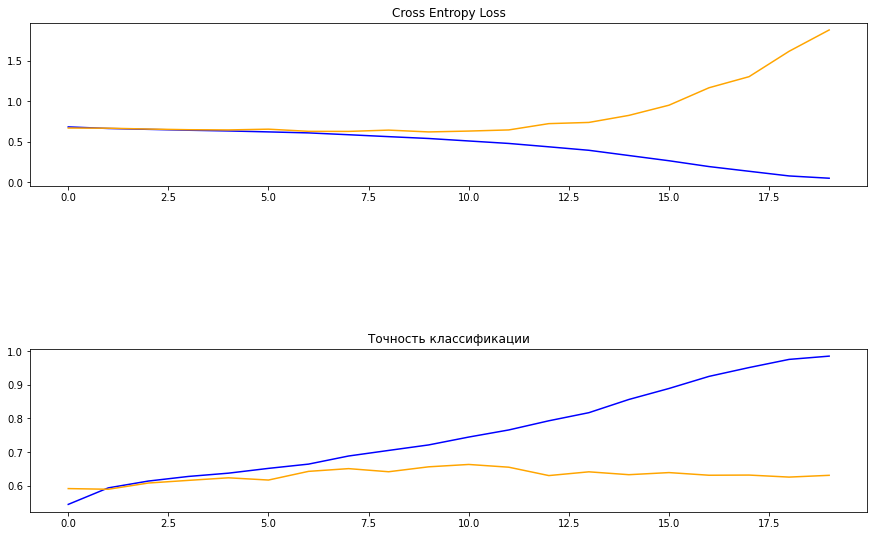

In [38]:
from matplotlib import pyplot
import sys
summarize_diagnostics(history)

In [134]:
from matplotlib import pyplot as plt
import cv2
import matplotlib.image as mpimg

def glcm(image,shiftx,shifty,levels,image2=None):#image2 is only for cross-band analysis
    
    """Calculate glcm"""
    image = (np.around(image*levels)).astype(np.uint8)
    if image2 is None:
        temp = image
    else:
        image2 = (np.around(image2*levels)).astype(np.uint8)
        temp = image2
    glcm = np.zeros((levels,levels), dtype=np.uint8)
    Nr, Na = image.shape
    for i in range(Nr-shifty):
        for j in range(Na-shiftx):
            glcm[image[i,j], temp[i+shifty, j+shiftx]]+=1
    return glcm

img = mpimg.imread('real.png')

R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
'''imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
Gray = glcm(imgGray,1,1,256)'''
f = np.fft.fft2(R)
fshift = np.fft.fftshift(f)
fshift+=epsilon
magnitude_spectrum = 20*np.log(np.abs(fshift))
Red = glcm(magnitude_spectrum,1,1,256)
Green = glcm(G,1,1,256)
Blue = glcm(B,1,1,256)
RG = glcm(R,0,0,256,G)
RB = glcm(R,0,0,256,B)
GB = glcm(G,0,0,256,B)

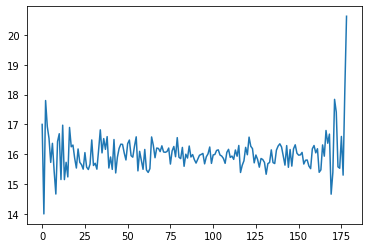

In [137]:
plt.plot(azimuthalAverage(Red))

In [104]:
comb1 = Red+Green+Blue+RG+RB+GB
#comb2 = RG+RB+GB
radial1 = azimuthalAverage(comb1)
#radial2 = azimuthalAverage(comb2)

Real image


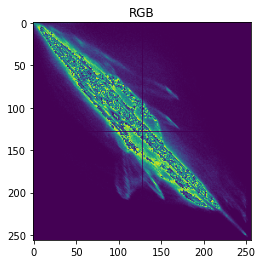

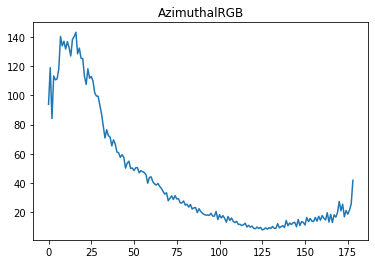

"plt.imshow(comb2)\nplt.title('RGRBGB')\nplt.show()\nplt.plot(radial2)\nplt.title('AzimuthalRGRBGB')\nplt.show()"

In [105]:
print('Real image')
plt.imshow(comb1)
plt.title('RGB')
plt.show()
plt.plot(radial1)
plt.title('AzimuthalRGB')
plt.show()
'''plt.imshow(comb2)
plt.title('RGRBGB')
plt.show()
plt.plot(radial2)
plt.title('AzimuthalRGRBGB')
plt.show()'''

Fake image


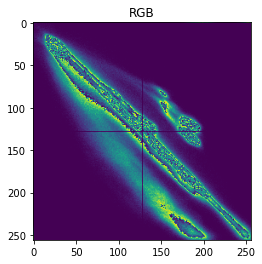

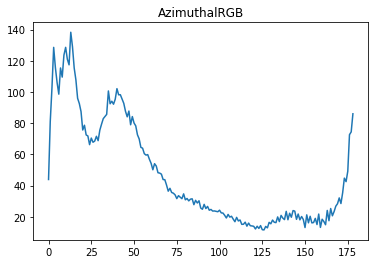

"plt.imshow(comb2)\nplt.title('RGRBGB')\nplt.show()\nplt.plot(radial2)\nplt.title('AzimuthalRGRBGB')\nplt.show()"

In [102]:
print('Fake image')
plt.imshow(comb1)
plt.title('RGB')
plt.show()
plt.plot(radial1)
plt.title('AzimuthalRGB')
plt.show()
'''plt.imshow(comb2)
plt.title('RGRBGB')
plt.show()
plt.plot(radial2)
plt.title('AzimuthalRGRBGB')
plt.show()'''

In [42]:
glcm_total = np.zeros((256, 256, 6))
glcm_total.shape
glcm_total[:,:,0] = Red
glcm_total[:,:,1] = Green
glcm_total[:,:,2] = Blue
glcm_total[:,:,3] = RG
glcm_total[:,:,4] = RB
glcm_total[:,:,5] = GB
glcm_total=glcm_total.reshape(1,256,256,6)
print(glcm_total.shape)

(1, 256, 256, 6)


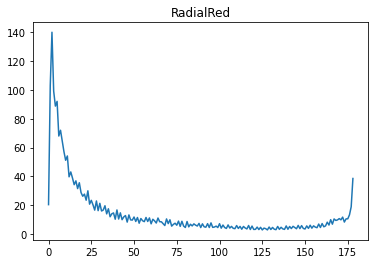

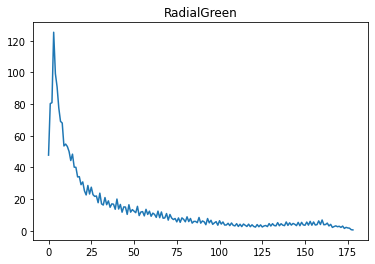

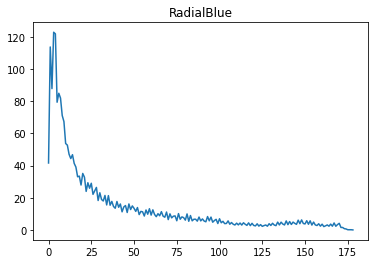

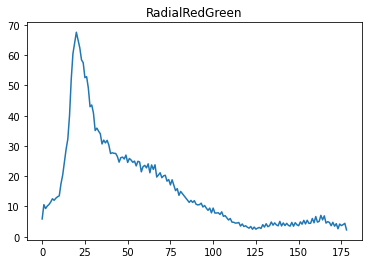

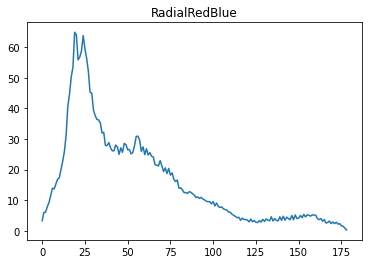

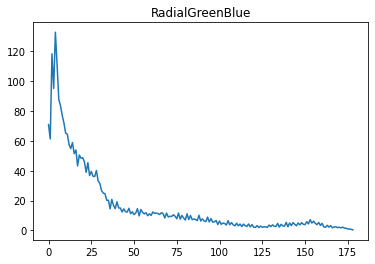

In [11]:
plt.plot(RadialRed)
plt.title('RadialRed')
plt.show()
plt.plot(RadialGreen)
plt.title('RadialGreen')
plt.show()
plt.plot(RadialBlue)
plt.title('RadialBlue')
plt.show()
plt.plot(RadialRedGreen)
plt.title('RadialRedGreen')
plt.show()
plt.plot(RadialRedBlue)
plt.title('RadialRedBlue')
plt.show()
plt.plot(RadialGreenBlue)
plt.title('RadialGreenBlue')
plt.show()

In [6]:
RadialRed.shape

(179,)

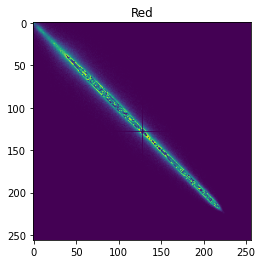

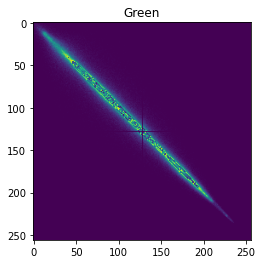

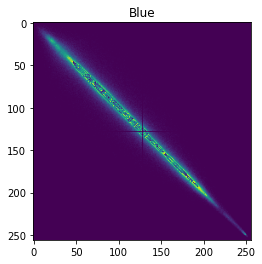

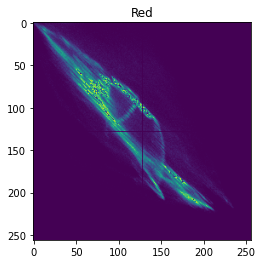

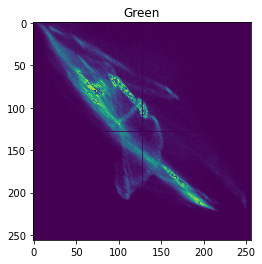

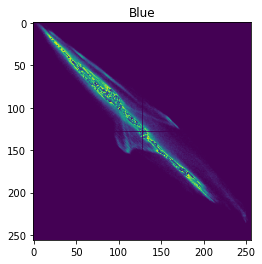

In [53]:
plt.imshow(Red)
plt.title('Red')
plt.show()
plt.imshow(Green)
plt.title('Green')
plt.show()
plt.imshow(Blue)
plt.title('Blue')
plt.show()
plt.imshow(RG)
plt.title('Red')
plt.show()
plt.imshow(RB)
plt.title('Green')
plt.show()
plt.imshow(GB)
plt.title('Blue')
plt.show()

In [123]:
import numpy as np
from tqdm import tqdm
x_new = np.zeros((X.shape[0],179,6))
def getSpectrum(x,f=None):
    f = np.fft.fft2(x)
    fshift = np.fft.fftshift(f)
    if f is None:
        phase_spectrum = np.angle(fshift)
        return phase_spectrum
    else:
        fshift+=epsilon
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        return magnitude_spectrum
def getPhaseSpectrumVector(x):
    temp = np.zeros((179,6))
    temp[:,0] = azimuthalAverage(x[:,:,0])
    temp[:,1] = azimuthalAverage(x[:,:,1])
    temp[:,2] = azimuthalAverage(x[:,:,2])
    temp[:,3] = azimuthalAverage(x[:,:,3])
    temp[:,4] = azimuthalAverage(x[:,:,4])
    temp[:,5] = azimuthalAverage(x[:,:,5])
    '''temp[:,6] = azimuthalAverage(getSpectrum(x[:,:,0],1))
    temp[:,7] = azimuthalAverage(getSpectrum(x[:,:,1],1))
    temp[:,8] = azimuthalAverage(getSpectrum(x[:,:,2],1))
    temp[:,9] = azimuthalAverage(getSpectrum(x[:,:,3],1))
    temp[:,10] = azimuthalAverage(getSpectrum(x[:,:,4],1))
    temp[:,11] = azimuthalAverage(getSpectrum(x[:,:,5],1))'''
    return temp
for i in tqdm(range(X.shape[0])):
    #x_new[i,:,:,0] = X[i,:,:,0]- X[i,:,:,1]- X[i,:,:,2]#+++ ~ 0.8 | ++- ~ 0.79 | +-+ ~ 0,69 | +-- ~ 0.73
    #x_new[i,:,0] = azimuthalAverage(X[i,:,:,0]+X[i,:,:,1]+X[i,:,:,2]+X[i,:,:,3]+X[i,:,:,4]+X[i,:,:,5])#+++ ~ 0.76 | ++- ~ 0.74 | +-+ 0,67 | +-- 0,65
    '''x_new[i,:,:,2] = X[i,:,:,0]+ X[i,:,:,1]- X[i,:,:,2]
    x_new[i,:,:,3] = X[i,:,:,3]+ X[i,:,:,4]- X[i,:,:,5]
    x_new[i,:,:,4] = X[i,:,:,0]- X[i,:,:,1]+ X[i,:,:,2]
    x_new[i,:,:,5] = X[i,:,:,3]- X[i,:,:,4]+ X[i,:,:,5]'''
    #magnitude_spectrum = 20*np.log(np.abs(fshift))
    x_new[i,:,:] = getPhaseSpectrumVector(X[i,:,:,:])
    #x_new[i,:,:,7] = X[i,:,:,3]+ X[i,:,:,4]+ X[i,:,:,5]
    #x_new[i,:,:,6] = X[i,:,:,0]- X[i,:,:,1]- X[i,:,:,2]
    #x_new[i,:,:,7] = X[i,:,:,3]- X[i,:,:,4]- X[i,:,:,5]
#(256,256,6) test 0.81 20 epochs
#(256,256,1) ++++++ 0.79 20 epochs 
# 





  0%|                                                                                          | 0/500 [00:00<?, ?it/s]



  0%|▎                                                                                 | 2/500 [00:00<00:26, 18.67it/s]



  1%|▊                                                                                 | 5/500 [00:00<00:24, 19.95it/s]



  2%|█▎                                                                                | 8/500 [00:00<00:24, 20.33it/s]



  2%|█▊                                                                               | 11/500 [00:00<00:24, 20.26it/s]



  3%|██▎                                                                              | 14/500 [00:00<00:24, 20.04it/s]



  3%|██▊                                                                              | 17/500 [00:00<00:24, 19.72it/s]



  4%|███▏                                                                             | 20/500 [00:00<00:23, 20.18it/s]



  5%|███▋   

 66%|████████████████████████████████████████████████████▋                           | 329/500 [00:16<00:08, 19.67it/s]



 66%|█████████████████████████████████████████████████████                           | 332/500 [00:16<00:08, 19.87it/s]



 67%|█████████████████████████████████████████████████████▍                          | 334/500 [00:16<00:08, 19.87it/s]



 67%|█████████████████████████████████████████████████████▉                          | 337/500 [00:16<00:08, 20.01it/s]



 68%|██████████████████████████████████████████████████████▍                         | 340/500 [00:16<00:07, 20.15it/s]



 69%|██████████████████████████████████████████████████████▉                         | 343/500 [00:17<00:07, 20.12it/s]



 69%|███████████████████████████████████████████████████████▎                        | 346/500 [00:17<00:07, 19.74it/s]



 70%|███████████████████████████████████████████████████████▋                        | 348/500 [00:17<00:07, 19.33it/s]



 70%|███████████

In [124]:
x_new.shape

(500, 179, 6)